# 모듈 호출

In [1]:
# 파이토치 불러오기
import torch
import torch.nn as nn

# 데이터셋 불러오기
from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10

# 데이터 로더
from torch.utils.data.dataloader import DataLoader

# 최적화 알고리즘
from torch.optim import optimizer

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

In [2]:
# 시드 고정
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

# 데이터 호출

In [4]:
# 데이터 호출(CIFAR 10)
path = '/home/helpme/data/CIFAR10'


train_data = CIFAR10(
    root = path,
    train=True,
    download=True,
    transform=transform
)

test_data = CIFAR10(
    root = path,
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


# 이미지 정규화

In [5]:
# 이미지 정규화
imgs = np.array([img.numpy() for img, _ in train_data])
print(f'img shape : {imgs.shape}')

img shape : (50000, 3, 224, 224)


In [6]:
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

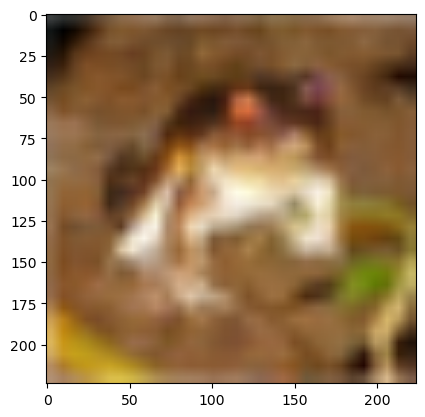

In [7]:
# frog로 보임
plt.imshow(imgs[0].transpose(1,2,0))

# 데이터 로더

In [8]:
batch_size = 256
num_workers = 4

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

In [9]:
print(train_dataloader.dataset)
print(f'Total {len(train_dataloader)} images in 1 batch')

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/helpme/data/CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Total 196 images in 1 batch


# 모델 생성

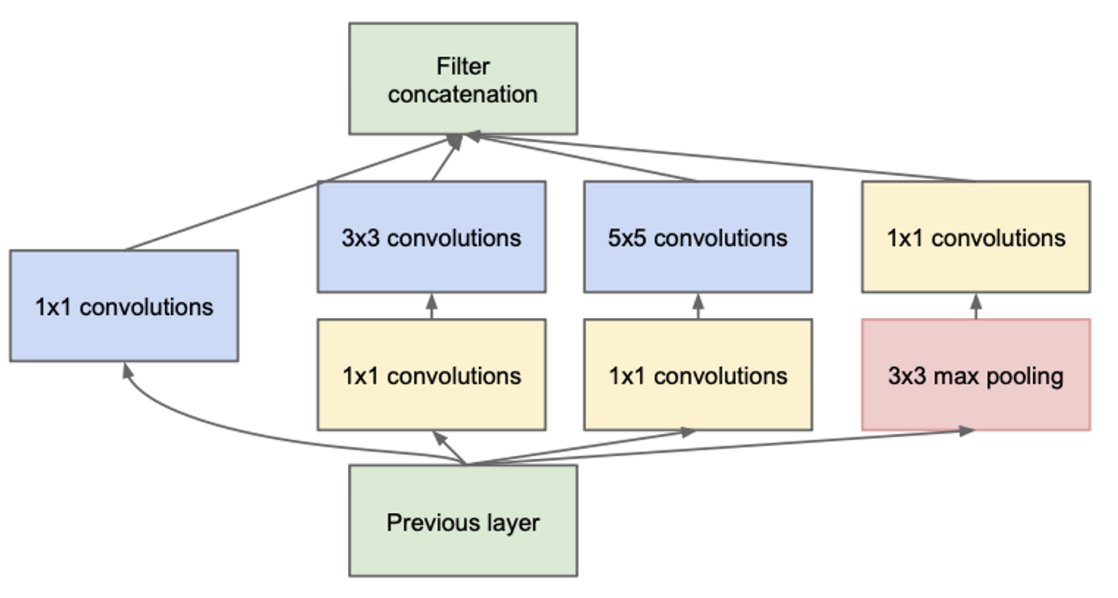

In [10]:
# 인셉션 모듈 만들기
# input을 받으면 각각 1*1, 1*1 -> 3*3, 1*1 -> 5*5, 3*3 -> 1*1 을 거친 4개의 값을 concatenation을 해주면 됨

class inception_module(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_in, ch3x3_out, ch5x5_in, ch5x5_out, pool):
        super(inception_module, self).__init__()
    
        # 1*1 conv
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=ch1x1, kernel_size=1), # 1x1 conv
            nn.ReLU(inplace=True)
        )
        
        # 1*1 conv -> 3*3 conv
        self.conv3x3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=ch3x3_in, kernel_size=1), # 1*1 conv
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=ch3x3_in, out_channels=ch3x3_out, kernel_size=3, padding=1), # 3x3 conv
            nn.ReLU(inplace=True),
        )

        # 1*1 conv -> 5*5 conv
        self.conv5x5 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=ch5x5_in, kernel_size=1), # 1*1 conv
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=ch5x5_in, out_channels=ch5x5_out, kernel_size=5, stride=1, padding=2), # 5x5 conv
            nn.ReLU(inplace=True),
        )

        # 3*3 max pool -> 1*1 conv 
        self.pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1), # 3x3 maxpool 
            nn.Conv2d(in_channels=in_channels, out_channels=pool, kernel_size=1), # 1x1 conv
            nn.ReLU(inplace=True)
        )

    def forward(self, x : torch.Tensor) -> torch.Tensor: # 속성 명시
        # 각 모듈별 데이터 input 
        out1 = self.conv1x1(x)
        out2 = self.conv3x3(x)
        out3 = self.conv5x5(x)
        out4 = self.pool(x)

        # 각 모듈별 결과 concat
        output = torch.cat([out1, out2, out3, out4], 1) 
        return output

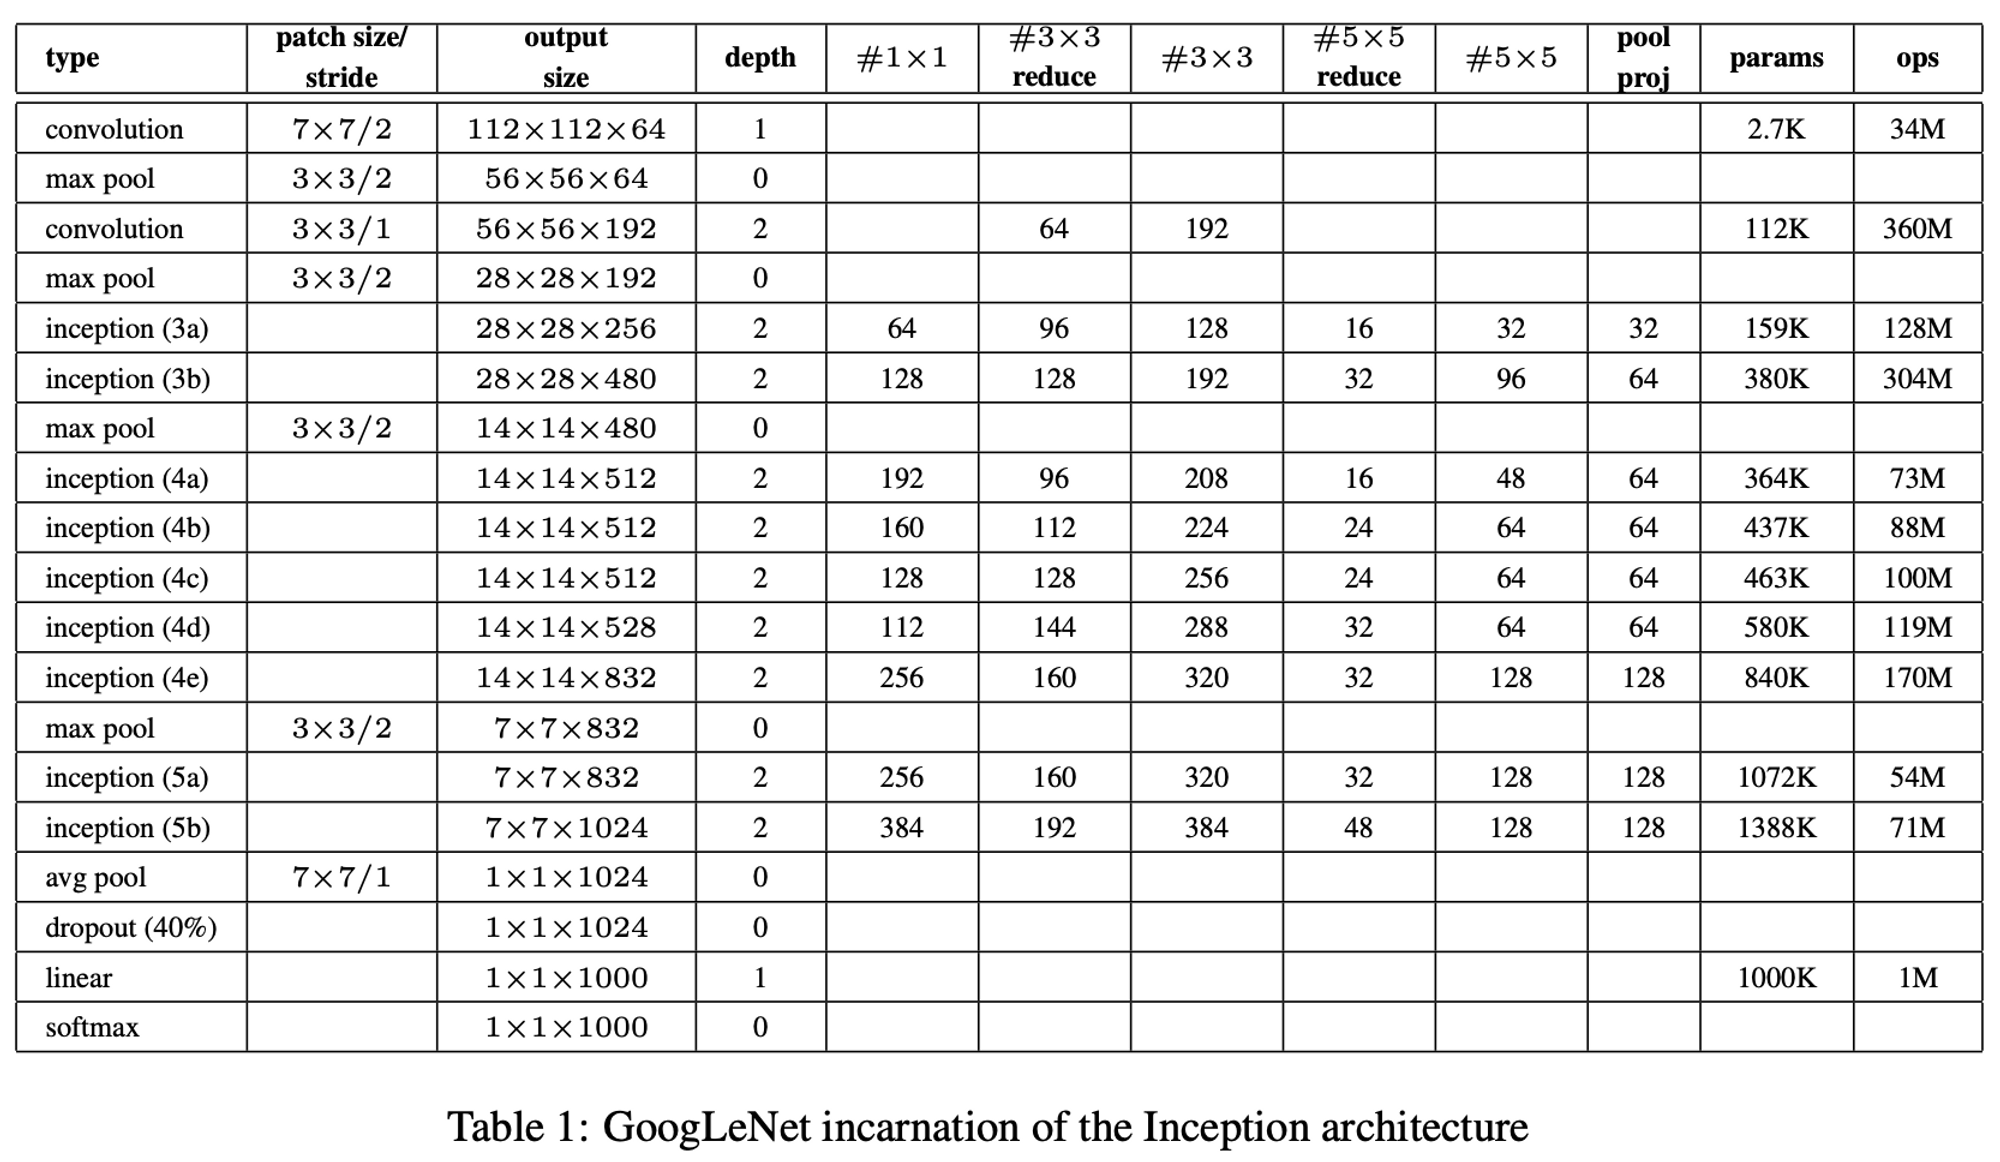

In [11]:
# 학습에 사용되는 auxiliary classifier
class Aux(nn.Module):
    def __init__(self, in_channels, num_classes) -> None:
        super().__init__()
        
        # 4a : average pooling(5*5 filter, stride 3, result = 4*4*512)
        # 4d : average pooling(5*5 filter, stride 3, result = 4*4*528)
        self.avgpool =  nn.AvgPool2d(kernel_size=5, stride=3, padding=1) 

        # 1*1 conv with 128 filters, + relu        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )

        # fc layer with 1024 units + relu
        # dropout layer with 70% ratio
        self.fc = nn.Sequential(
                nn.Linear(4*4*128, 1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.7),
                nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv(x)
        x = torch.flatten(x, 1) # flatten
        x = self.fc(x)
        return x
        

In [12]:
# GoogLeNet 구현
class GoogLeNet(nn.Module):
    def __init__(self, training, num_classes)-> None:
        super().__init__()
        
        self.training = True
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(2)
        )
        
        # inception 3
        self.inception_3a = inception_module(in_channels=192, ch1x1=64, ch3x3_in=96, ch3x3_out=128, ch5x5_in=16, ch5x5_out=32, pool=32)
        self.inception_3b = inception_module(256, 128, 128, 192, 32, 96, 64)
        self.maxpool_3 = nn.MaxPool2d(3,2,1)

        # inception 4
        self.inception_4a = inception_module(480, 192, 96, 208, 16, 48, 64)
        self.aux1 = Aux(512, num_classes) # 보조 학습기 1

        self.inception_4b = inception_module(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = inception_module(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = inception_module(512, 112, 144, 288, 32, 64, 64)
        self.aux2 = Aux(528, num_classes) # 보조 학습기 2

        self.inception_4e = inception_module(528, 256, 160, 320, 32, 128, 128)
        self.maxpool_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # inception 5
        self.inception_5a = inception_module(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = inception_module(832, 384, 192, 384, 48, 128, 128)

        # fully connected
        self.avg = nn.AvgPool2d(kernel_size=7, stride=1) # adaptive avgpool로 대체 가능
        self.dropout = nn.Dropout2d(0.4) # 40%
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool_3(x)

        x = self.inception_4a(x)
        if self.training :
            aux_out1 = self.aux1(x)
        
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        if self.training:
            aux_out2 = self.aux2(x)

        x = self.inception_4e(x)
        x = self.maxpool_4(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)

        x = self.avg(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)

        if self.training:
            return [aux_out1, aux_out2, x]
        else :
            return x

In [13]:
model = GoogLeNet(training=True, num_classes=10)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
model.to(device)

Using cuda device


GoogLeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  )
  (inception_3a): inception_module(
    (conv1x1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv3x3): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=

# 모델 확인

In [14]:
from torchsummary import summary
model = GoogLeNet(training=True, num_classes=10).cuda()
summary(model, input_size=(3,224,224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
              ReLU-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
 LocalResponseNorm-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 192, 56, 56]         110,784
              ReLU-8          [-1, 192, 56, 56]               0
         MaxPool2d-9          [-1, 192, 28, 28]               0
LocalResponseNorm-10          [-1, 192, 28, 28]               0
           Conv2d-11           [-1, 64, 28, 28]          12,352
             ReLU-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          18,528
             ReLU-14           [-1, 96,

# 학습 loss, 최적화 알고리즘 확인

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

criterion.to(device=device)
model.to(device=device)

GoogLeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  )
  (inception_3a): inception_module(
    (conv1x1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv3x3): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=

# 학습 
보조 학습기가 있기 때문에 loss를 추후 합산해야함(각 보조 학습기의 가중치는 0.3)

In [16]:
# 학습
num_epochs = 100 # 에폭 설정

loss_arr = []
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_dataloader):  
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        output_1, output_2, output_3 = model(images) # 모델 예측 시행
    
        # 예측에 따른 손실 계산 및 출력
        loss_1 = criterion(output_1, labels)  # 보조분류기 1
        loss_2 = criterion(output_2, labels)  # 보조분류기 2
        loss_3 = criterion(output_3, labels)  # 최종 결과물

        loss = loss_1 * 0.3 + loss_2 * 0.3 + loss_3

        # backward pass 
        optimizer.zero_grad() # 가중치 변화를 0으로 만들고
        loss.backward() # 역전파를 수행하고
        optimizer.step() # 가중치를 갱신

        running_loss += loss.item()
        loss_arr.append(loss.item())
        # 100번에 한번씩 loss 출력
        if i % 19 == 18: 
            print(f'Training epoch : {epoch+1}, [{i * len(images)} / {len(train_dataloader.dataset)}] ({100 * i / len(train_dataloader):0.0f}%), Loss : {running_loss/19:0.6f}')
            running_loss = 0.0

print('학습종료!')

Training epoch : 1, [4608 / 50000] (9%), Loss : 3.684506
Training epoch : 1, [9472 / 50000] (19%), Loss : 3.684861
Training epoch : 1, [14336 / 50000] (29%), Loss : 3.682943
Training epoch : 1, [19200 / 50000] (38%), Loss : 3.664881
Training epoch : 1, [24064 / 50000] (48%), Loss : 3.593265
Training epoch : 1, [28928 / 50000] (58%), Loss : 3.402325
Training epoch : 1, [33792 / 50000] (67%), Loss : 3.322029
Training epoch : 1, [38656 / 50000] (77%), Loss : 3.286353
Training epoch : 1, [43520 / 50000] (87%), Loss : 3.252620
Training epoch : 1, [48384 / 50000] (96%), Loss : 3.220800
Training epoch : 2, [4608 / 50000] (9%), Loss : 3.200518
Training epoch : 2, [9472 / 50000] (19%), Loss : 3.143412
Training epoch : 2, [14336 / 50000] (29%), Loss : 3.130636
Training epoch : 2, [19200 / 50000] (38%), Loss : 3.116177
Training epoch : 2, [24064 / 50000] (48%), Loss : 3.059557
Training epoch : 2, [28928 / 50000] (58%), Loss : 3.064427
Training epoch : 2, [33792 / 50000] (67%), Loss : 3.048834
Tra

# 학습 결과 loss 시각화

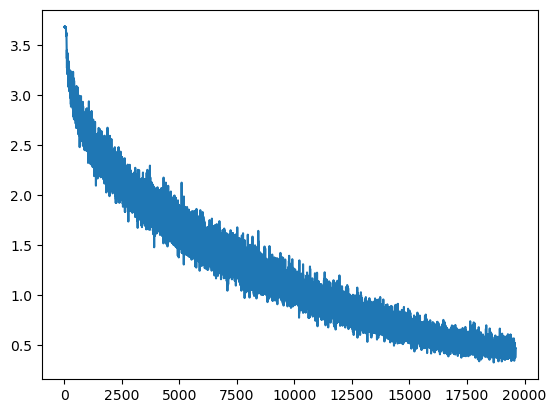

In [17]:
plt.plot(loss_arr)
plt.show()

# 테스트

In [18]:
# test 
model.eval() # drop out 같은 학습에만 필요하고 test에는 불필요한 층을 비활성화

# 클래스 개수대로 정답 개수, 총 개수 구하기
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


with torch.no_grad(): # gradient 연산을 멈춘 상태로 계산, 메모리 절약 및 연산속도 증가
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # 결과 예측
        outputs = model(images) # 모델 실행

        # 이미지가 가질 수 있는 라벨 중 가장 높은 확률과 인덱스(라벨)를 출력
        _, predicted = torch.max(outputs.data, dim=1) 

        # 라벨과 정답이 일치하는지 확인
        c = (predicted == labels).squeeze()

        # 한번에 배치 사이즈만큼 예측하기 때문에 batch_size 개수만큼 예측 결과가 나옴
        for i in range(len(data)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [19]:
# test 결과 확인
total_correct = 0
total = 0

for i in range(10):
    total_correct += class_correct[i]
    total += class_total[i]
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

print(f'Total accuracy : {100 * total_correct/total:0.2f}%')

Accuracy of airplane : 83 %
Accuracy of automobile : 80 %
Accuracy of  bird : 75 %
Accuracy of   cat : 37 %
Accuracy of  deer : 50 %
Accuracy of   dog : 55 %
Accuracy of  frog : 80 %
Accuracy of horse : 100 %
Accuracy of  ship : 90 %
Accuracy of truck : 85 %
Total accuracy : 68.75%
